Para comenzar, importamos los paquetes necesarios para nuestro programa

In [40]:
import pyspark
from pyspark.sql import SparkSession
from matplotlib import pyplot as plt
from datetime import date
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.types import *
from pyspark.sql.functions import udf, pandas_udf, PandasUDFType
spark = SparkSession.builder.getOrCreate()

Introducimos la base de datos que utilizaremos y la filtramos, eliminando las columnas que no nos son de utilidad

In [41]:
df_original = spark.read.json('data100000.json')
df = df_original.drop('_id','idplug_base','idunplug_base','track', 'zip_code')
df = df.where('user_type!= 3')
df = df.where('ageRange!= 0')
porcentaje_optimo = df.count() * 100 / df_original.count()
print('Nos quedamos con un', porcentaje_optimo, '% de los datos, ya que el resto no nos aportan informacion acerca del estudio que estamos realizando')



Nos quedamos con un 49.872 % de los datos, ya que el resto no nos aportan informacion acerca del estudio que estamos realizando


Generamos una nueva base de datos, añadiendole una columna que indica el día de la semana en el que estamos, siendo 0 el lunes y 6 el domingo. A esta nueva base de datos la llamamos df1

In [42]:
def get_weekday(hourtime):

    try:
        year = int(hourtime[:4])
        month = int(hourtime[5:7])
        day = int(hourtime[8:10])

        return date(year, month, day).weekday()
    except BaseException:
        year = int(hourtime[10:14])
        month = int(hourtime[15:17])
        day = int(hourtime[18:20])

        return date(year, month, day).weekday()

day_func = udf(lambda x: get_weekday(x), IntegerType())
df1 = df.withColumn('get_weekday', day_func(df['unplug_hourTime']))

Realizamos lo mismo que para los dias de la semana, pero esta vez para el año. Generamos una nueva base de datos (df2), añadiendole a df1 una columna que nos indica el año. Acto seguido, generamos dos bases de datos diferenciadas, una para 2018 (df2018) y otra para 2020 (df2020)

In [43]:
def get_year(hourtime):
    try:
        year = int(hourtime[:4])
        return year

    except BaseException:
        year = int(hourtime[10:14])
        return year

year_func = udf(lambda x: get_year(x), IntegerType())    
df2 = df1.withColumn('get_year', year_func(df1['unplug_hourTime']))
df2018 = df2.filter(df2['get_year']==2018)
df2020 = df2.filter(df2['get_year']==2020)


voy  a hacer el tratamiento de datos de edades:
primero hago un recuento del total de personas que usaron la bicicleta cada dia de la semana en cada año

generamos data frames para cada de edad, de manera que podemos ver cuantas personas de cada edad usan la bicicleta cada dia de la semana, para, posteriormente, calcular porcentajes.

In [44]:
weekday18 = df2018.groupBy('get_weekday').count()
weekday20 = df2020.groupBy('get_weekday').count()
tablap18 = weekday18.toPandas()
d18 = dict([(a, b) for a,b in zip(tablap18['get_weekday'], tablap18['count'])])
tablap20 = weekday20.toPandas()
d20 = dict([(a, b) for a,b in zip(tablap20['get_weekday'], tablap20['count'])])


In [45]:
def tablas_edades(df):  #crea tablas para cada año y para cada rango de edad,  y las almacena en lista_tablas
    lista_tablas = []
    for i in range(1, 7):
        tabla = df.filter(df['ageRange'] == i)                 #edades2018_0 = df2018.filter(df2018['ageRange'] == 0)
        tabla = tabla.groupBy(tabla['get_weekday']).count()    #edades2018_0 = edades2018_0.groupBy(edades2018_0['get_weekday']).count() saca el recuento por                                                                   dias de la semana
        lista_tablas.append(tabla)
    return lista_tablas

def muestra_tablas_edades(df): #muestra las tablas 
    tablas = tablas_edades(df)
    for i in range(len(tablas)):
        tablas[i].show()

In [46]:
def pasar_Pandas(df):
    lista_pandas = []
    for i in range(len(tablas_edades(df))):
        tablap = tablas_edades(df)[i].toPandas()
        lista_pandas.append(tablap)
    return lista_pandas
def pasar_diccionario(df):
    diccionarios = []
    for i in range(len(pasar_Pandas(df))):
        d = dict([(a, b) for a,b in zip(pasar_Pandas(df)[i]['get_weekday'], pasar_Pandas(df)[i]['count'])])
        diccionarios.append(d)
    return diccionarios
lisdicc18 = pasar_diccionario(df2018)
lisdicc20 = pasar_diccionario(df2020)
#lista de diccionarios. Cada diccionario es para una franja de edad e indica el dia de la semana y el número de usos ese dia.


In [47]:
print(d18)
print(lisdicc18)
print(d20) 
print(lisdicc20)

{1: 4935, 6: 2931, 3: 4931, 5: 3051, 4: 4454, 2: 4806, 0: 4644}
[{1: 18, 6: 15, 3: 18, 5: 16, 4: 21, 2: 8, 0: 7}, {1: 90, 6: 59, 3: 115, 5: 78, 4: 79, 2: 70, 0: 95}, {1: 480, 6: 416, 3: 482, 5: 429, 4: 470, 2: 466, 0: 493}, {1: 2638, 6: 1592, 3: 2663, 5: 1675, 4: 2383, 2: 2599, 0: 2444}, {1: 1661, 6: 818, 3: 1612, 5: 825, 4: 1469, 2: 1635, 0: 1566}, {1: 48, 6: 31, 3: 41, 5: 28, 4: 32, 2: 28, 0: 39}]
{1: 3100, 6: 1982, 3: 3275, 5: 2250, 4: 3207, 2: 3399, 0: 2905}
[{1: 6, 6: 4, 3: 4, 5: 4, 4: 10, 2: 9, 0: 6}, {1: 37, 6: 25, 3: 26, 5: 27, 4: 36, 2: 25, 0: 26}, {1: 219, 6: 225, 3: 292, 5: 241, 4: 263, 2: 267, 0: 270}, {1: 1510, 6: 986, 3: 1591, 5: 1145, 4: 1550, 2: 1668, 0: 1365}, {1: 1296, 6: 712, 3: 1324, 5: 810, 4: 1314, 2: 1389, 0: 1212}, {1: 32, 6: 30, 3: 38, 5: 23, 4: 34, 2: 41, 0: 26}]


calculamos los porcentajes, cogiendo el total de cada dia de la semana de weekdayxx, y la cantidad de uso de cada grupo de personas edadesxxxx_x

In [48]:
def to_porcentaje(tot, lis):
    p = []
    for i in range(len(lis)):
        t = []
        for j in range(7):
            a = 100*lis[i][j]/tot[j]
            t.append(a)
        p.append(t)
    return p

Graficamos, generando una grafica por dia de la semana que nos indique el uso de la bicicleta por grupo de personas. 

2018


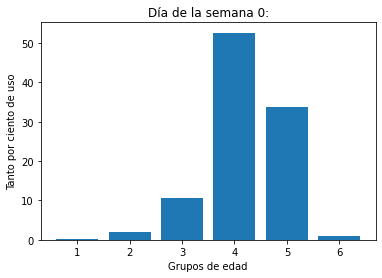

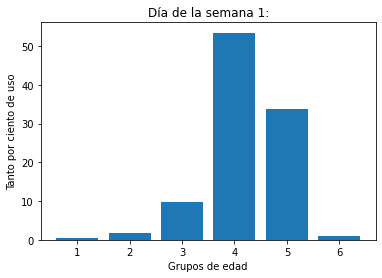

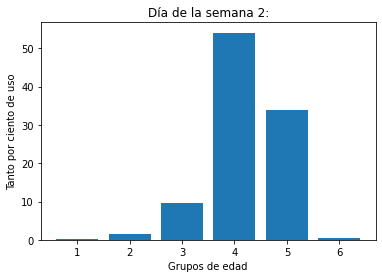

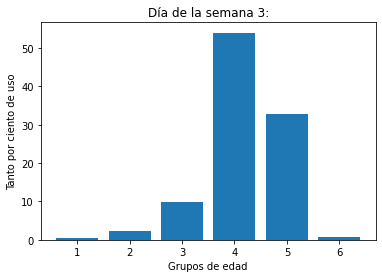

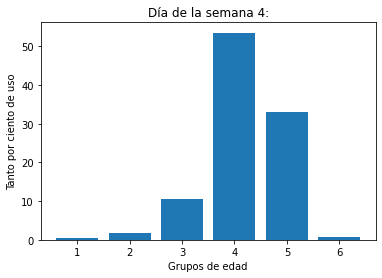

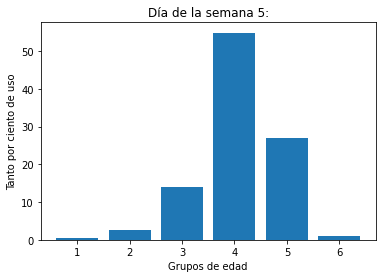

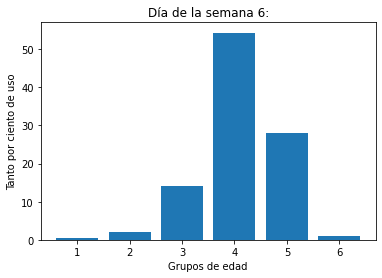

2020


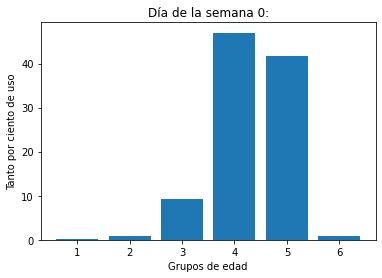

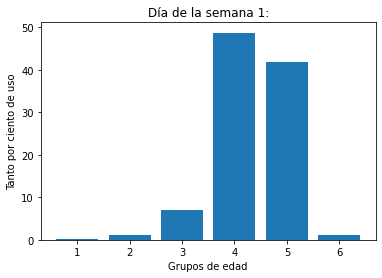

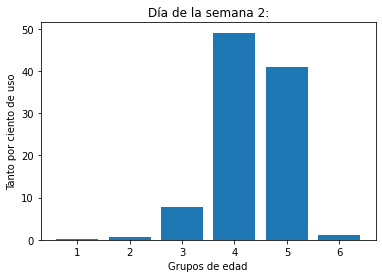

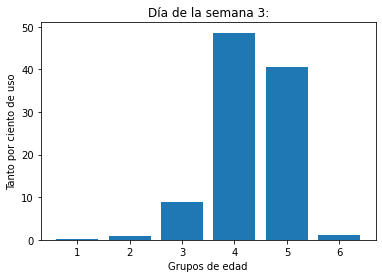

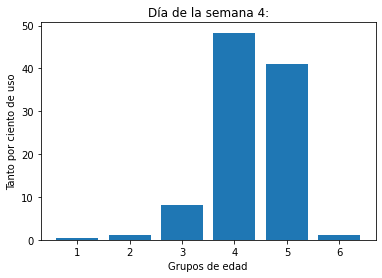

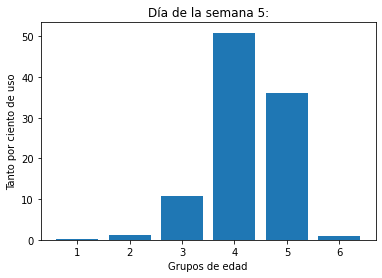

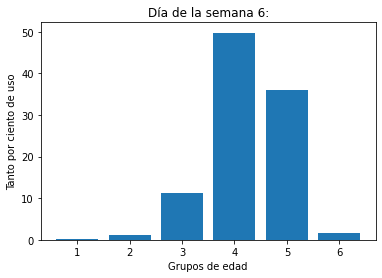

In [49]:
import matplotlib.pyplot as plt
def plotear(x):
    plt.figure()
    for i in range(7):
        edad = [1,2,3,4,5,6]
        y = []
        for j in range(len(x)):
            day = x[j][i]
            y.append(day)
        plt.subplot()
        plt.xlabel('Grupos de edad')
        plt.ylabel('Tanto por ciento de uso')
        plt.title('Día de la semana %d:' %i)
        plt.bar(edad, y)
        plt.show()
print('2018')
plotear(to_porcentaje(d18, lisdicc18))
print('2020')
plotear(to_porcentaje(d20, lisdicc20))


Ahora veamos que ocurre si juntamos de lunes a jueves y de viernes a domingo, para comparar las diferencias entre fines de semana y dias de diario.

In [50]:
def unir_laborables(x):
    lab = []
    for i in range(len(x)): #la i recorre cada diccionario
        lab.append(x[i][0] + x[i][1] + x[i][2] + x[i][3])
    return lab
    
def unir_fds(x):
    fds = []
    for i in range(len(x)): #la i recorre cada diccionario
        fds.append(x[i][4] + x[i][5] + x[i][6])
    return fds

def suma(x):
    s= []
    l = unir_laborables(x)
    f = unir_fds(x)
    for i in range(len(x)):
        s.append(l[i]+f[i])
    return s

Veamos las diferencias porcentuales entre fines de semana+viernes y laborales. Ya que es claro los grupos de edad que mas usan el servicio, voy a ver dentro de cada grupo de personas cuanto uso hay los fines de semana y cuanto los dias de diario

2018


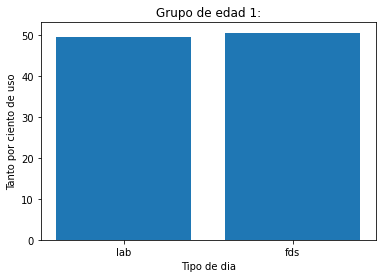

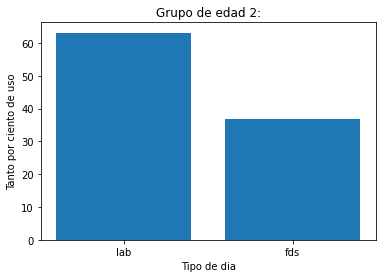

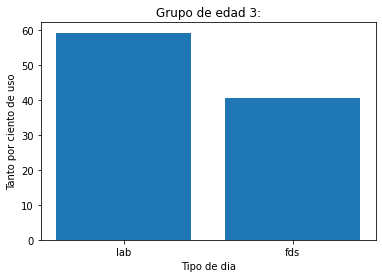

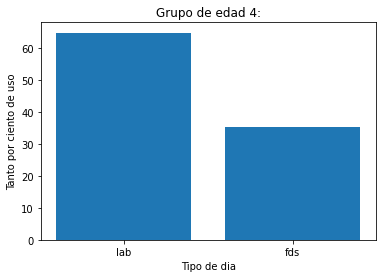

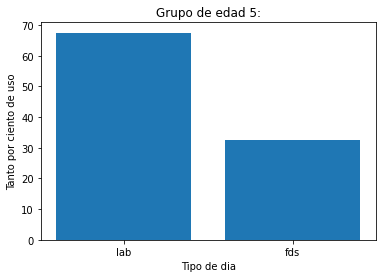

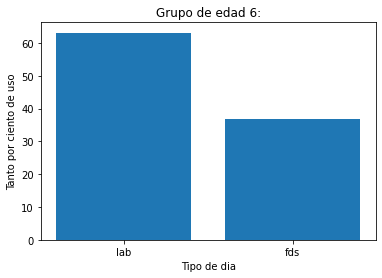

2020


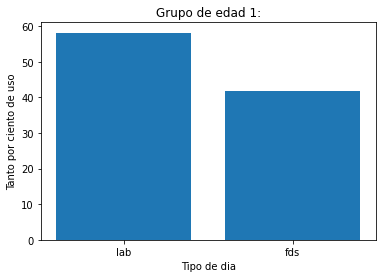

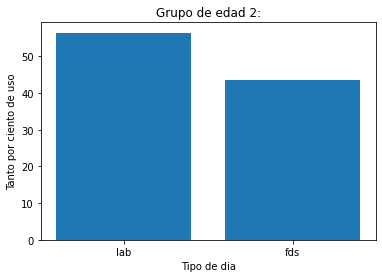

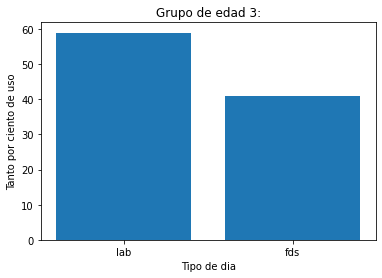

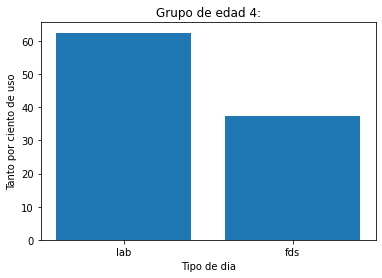

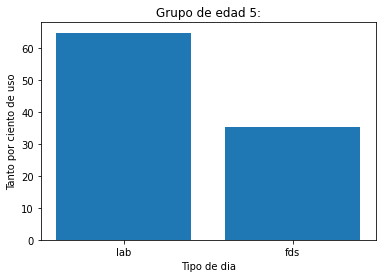

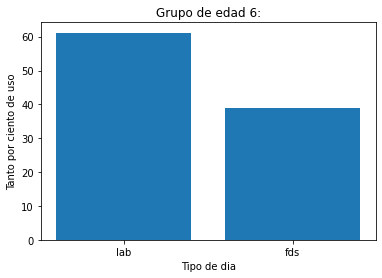

In [51]:
def to_porcentajelab(x):
    p = []
    for i in range(len(x)):
        a = 100*unir_laborables(x)[i]/suma(x)[i]
        p.append(a)
    return p
    
def to_porcentajefds(x):
    q = []
    for i in range(len(x)):
        b = 100*unir_fds(x)[i]/suma(x)[i]
        q.append(b)
    return q

def plotear2(x):
    plt.figure()
    for i in range(6):
        daytype = ['lab', 'fds'] 
        y = [to_porcentajelab(x)[i], to_porcentajefds(x)[i]]
        plt.subplot()
        plt.xlabel('Tipo de dia')
        plt.ylabel('Tanto por ciento de uso')
        plt.title('Grupo de edad %d:' %(i+1))
        plt.bar(daytype, y)
        plt.show()
print('2018')
plotear2(lisdicc18)
print('2020')
plotear2(lisdicc20)
